# Adapted from 2018 LST Bootcamp walkthrough

<div align="center" style="font-size: 2rem">

<img heoght="300px" src="https://cta-observatory.github.io/ctapipe/_images/ctapipe_logo.png" alt="ctapipe"/>



<p style="text-align: center">Maximilian Nöthe (@maxnoe), Kai A. Brügge (@mackaiver), T. Vuillaume (@vuillaut)</p>

</div>

In [46]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 14

plt.rcParams['figure.figsize']

[12.0, 8.0]

In [3]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

## General Information

### Design

* DL0 → DL3 analysis

* Currently some R0 → DL0 code to be able to analyze simtel files

* ctapipe is built upon the Scientific Python Stack, core dependencies are
  * numpy
  * scipy
  * astropy

### Developement

* ctapipe is developed as Open Source Software (Currently under MIT License) at <https://github.com/cta-observatory/ctapipe>

* We use the "Github-Workflow": 
  * Few people (e.g. @kosack, @mackaiver) have write access to the main repository
  * Contributors fork the main repository and work on branches
  * Pull Requests are merged after Code Review and automatic execution of the test suite

* Early developement stage ⇒ backwards-incompatible API changes might and will happen 

* Many open design questions ⇒ Core Developer Meetings

### What's there?

* Reading simtel simulation files
* Simple calibration, cleaning and feature extraction functions
* Camera and Array plotting
* Coordinate frames and transformations 
* Stereo-reconstruction using line intersections
  
 

### What's still missing?

* Easy to use "analysis builder"
* A "Standard Analysis"
* Good integration with machine learning techniques
* IRF calculation 
* Defining APIs for IO, instrument description access etc.
* Most code only tested on HESSIO simulations
* Documentation, e.g. formal definitions of coordinate frames 
 
 

### What can you do?

* Report issues
  * Hard to get started? Tell us where you are stuck
  * Tell user stories
  * Missing features

* Start contributing
  * ctapipe needs more workpower
  * Implement new reconstruction features

## A simple hillas analysis

### Reading in simtel files

In [104]:
from ctapipe.io import event_source
from ctapipe.utils.datasets import get_dataset_path

input_url = get_dataset_path('gamma_test_large.simtel.gz')

source = event_source(input_url, max_events=6)

In [105]:
for event in source:
    print('Id: {}, E = {:1.3f}, Telescopes: {}'.format(event.count, event.mc.energy, len(event.r0.tel)))

Id: 0, E = 0.571 TeV, Telescopes: 4
Id: 1, E = 1.864 TeV, Telescopes: 9
Id: 2, E = 1.864 TeV, Telescopes: 4
Id: 3, E = 1.864 TeV, Telescopes: 17
Id: 4, E = 1.864 TeV, Telescopes: 2
Id: 5, E = 0.464 TeV, Telescopes: 7


Each event is a `DataContainer` holding several `Field`s of data, which can be containers or just numbers.
Let's look a one event:

In [106]:
event

ctapipe.io.containers.DataContainer:
                    event_type: Event type
                          r0.*: Raw Data
                          r1.*: R1 Calibrated Data
                         dl0.*: DL0 Data Volume Reduced Data
                         dl1.*: DL1 Calibrated image
                         dl2.*: Reconstructed Shower Information
                          mc.*: Monte-Carlo data
                    mcheader.*: Monte-Carlo run header data
                        trig.*: central trigger information
                         count: number of events processed
                        inst.*: instrumental information (deprecated
                   pointing[*]: Telescope pointing positions

In [107]:
event.inst.subarray.camera_types

[CameraGeometry(cam_id='LSTCam', pix_type='hexagonal', npix=1855, cam_rot=0.0 rad, pix_rot=100.89299992867878 deg),
 CameraGeometry(cam_id='FlashCam', pix_type='hexagonal', npix=1764, cam_rot=0.0 rad, pix_rot=0.0 deg),
 CameraGeometry(cam_id='ASTRICam', pix_type='rectangular', npix=2368, cam_rot=0.0 rad, pix_rot=0.0 deg)]

In [108]:
event.mc.energy

<Quantity 0.46449643 TeV>

In [109]:
len(event.r0.tel), len(event.r1.tel)

(7, 7)

In [110]:
event.dl1.tel

Map(ctapipe.io.containers.DL1CameraContainer, {})

In [111]:
len(event.dl1.tel)

0

### Data calibration

As we saw, the data container only contains raw data (only the `r0` containers are filled)

So we use the `CameraCalibrator` factory to calibrate the event.

In [112]:
from ctapipe.calib import CameraCalibrator
from ctapipe.image.extractor import NeighborPeakWindowSum, LocalPeakWindowSum
calibrator = CameraCalibrator(image_extractor=NeighborPeakWindowSum())

In [113]:
calibrator(event)

In [114]:
len(event.dl1.tel)

7

In [115]:
event.dl1.tel.keys()

dict_keys([6, 10, 15, 18, 22, 27, 35])

In [117]:
event.dl1.tel[6]

ctapipe.io.containers.DL1CameraContainer:
                         image: Numpy array of camera image, after waveform
                                extraction.Shape: (n_chan, n_pixel)
                    pulse_time: Numpy array containing position of the pulse as
                                determined by the extractor.Shape: (n_chan,
                                n_pixel, n_samples)
                  gain_channel: boolean numpy array of which gain channel was
                                used for each pixel in the image

### Event displays

Let's use ctapipe's plotting facilities to plot the telescope images

In [118]:
tel_id = 6

In [119]:
camera = event.inst.subarray.tel[tel_id].camera
dl1 = event.dl1.tel[tel_id]

camera, dl1

(CameraGeometry(cam_id='FlashCam', pix_type='hexagonal', npix=1764, cam_rot=0.0 rad, pix_rot=0.0 deg),
 ctapipe.io.containers.DL1CameraContainer:
                          image: Numpy array of camera image, after waveform
                                 extraction.Shape: (n_chan, n_pixel)
                     pulse_time: Numpy array containing position of the pulse as
                                 determined by the extractor.Shape: (n_chan,
                                 n_pixel, n_samples)
                   gain_channel: boolean numpy array of which gain channel was
                                 used for each pixel in the image)

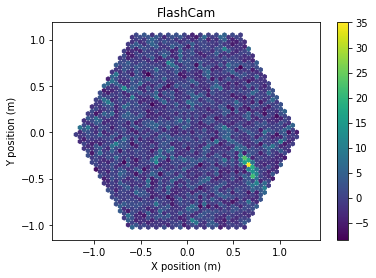

In [120]:
from ctapipe.visualization import CameraDisplay

display = CameraDisplay(camera)

display.image = dl1.image[0]
display.add_colorbar()

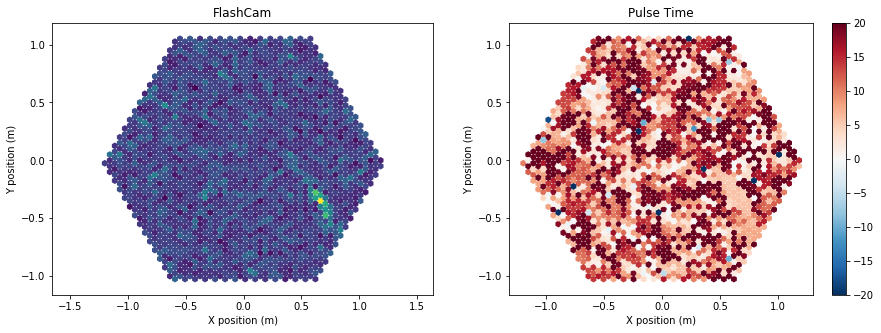

In [122]:
tel_id = 6
camera = event.inst.subarray.tel[tel_id].camera
dl1 = event.dl1.tel[tel_id]

fig, axes = plt.subplots(1, 2, figsize=(15,5))

display1 = CameraDisplay(camera, ax=axes[0])

display2 = CameraDisplay(camera, ax=axes[1])
display2.set_limits_minmax(-20,20)

display1.image = dl1.image[0]


axes[1].set_title('Pulse Time')
display2.image = dl1.pulse_time[0]
display2.cmap = 'RdBu_r'
display2.add_colorbar(ax=axes[1])

### Image Cleaning

In [123]:
from ctapipe.image.cleaning import tailcuts_clean

In [124]:
# unoptimized cleaning levels, copied from 
# https://github.com/tudo-astroparticlephysics/cta_preprocessing
cleaning_level = {
    'ASTRICam': (5, 7, 2),  # (5, 10)?
    'LSTCam': (3.5, 7.5, 2),  # ?? (3, 6) for Abelardo...
    'FlashCam': (4, 8, 2),  # there is some scaling missing?
}

In [125]:
boundary, picture, min_neighbors = cleaning_level[camera.cam_id]

pixels_with_signal = tailcuts_clean(
                        camera, 
                        dl1.image[0],
                        boundary_thresh=boundary,
                        picture_thresh=picture,
                        min_number_picture_neighbors=min_neighbors
                    )

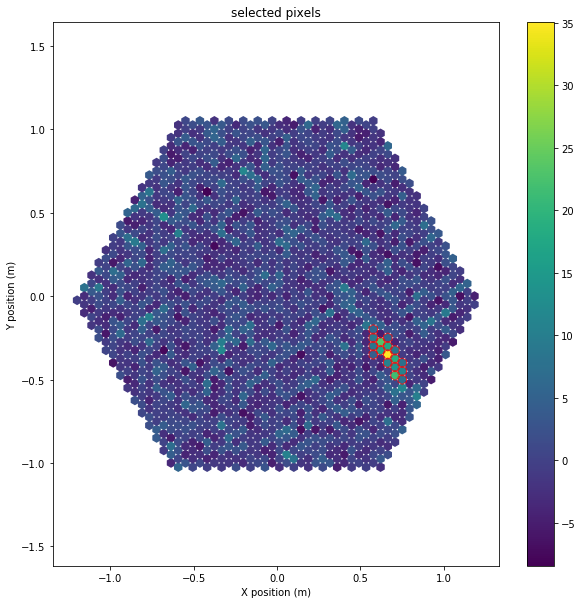

In [126]:
fig = plt.figure(figsize=(10, 10))

d1 = CameraDisplay(camera)

plt.title('selected pixels')
d1.image = dl1.image[0]
d1.add_colorbar()

d1.highlight_pixels(pixels_with_signal, color='red', linewidth=1)

### Image Parameters

In [127]:
from ctapipe.image import hillas_parameters, leakage, concentration
from ctapipe.image.timing_parameters import timing_parameters
from ctapipe.image.cleaning import number_of_islands

In [129]:
hillas = hillas_parameters(camera[pixels_with_signal], dl1.image[0][pixels_with_signal])

print(hillas)

{'intensity': 225.01367517384617,
 'kurtosis': 2.158111038761359,
 'length': <Quantity 0.0861119 m>,
 'phi': <Angle -0.49009633 rad>,
 'psi': <Angle -1.00328274 rad>,
 'r': <Quantity 0.75661764 m>,
 'skewness': 0.08801384709410831,
 'width': <Quantity 0.02688629 m>,
 'x': <Quantity 0.6675543 m>,
 'y': <Quantity -0.35614815 m>}


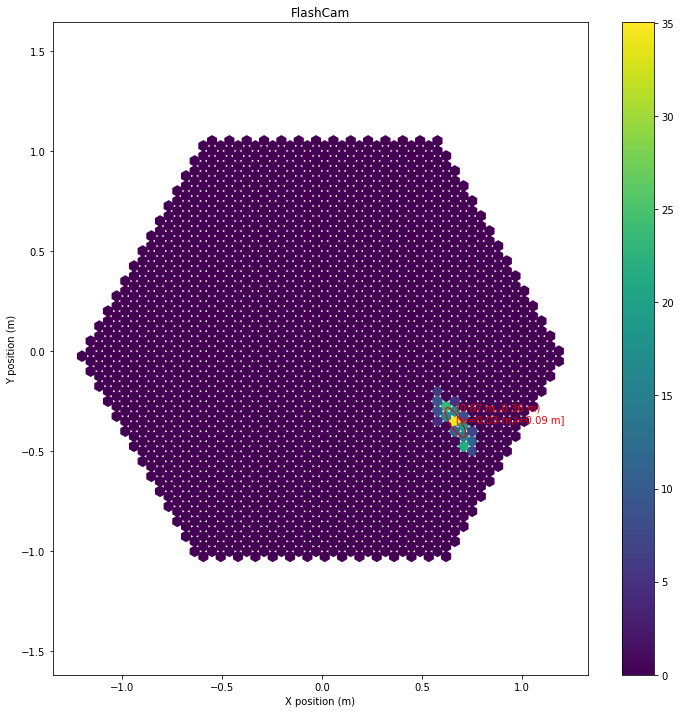

In [135]:
plt.figure(figsize=(12,12))
display = CameraDisplay(camera)

# set "unclean" pixels to 0
cleaned = dl1.image[0].copy()
cleaned[~pixels_with_signal] = 0.0

display.image = cleaned
display.add_colorbar()

display.overlay_moments(hillas, color='xkcd:red')

In [138]:
timing = timing_parameters(
    camera[pixels_with_signal],
    dl1.image[0][pixels_with_signal],
    dl1.pulse_time[0][pixels_with_signal],
    hillas,
)

print(timing)

{'deviation': 0.48550329412472126,
 'intercept': 5.903433936678778,
 'slope': <Quantity 3.52243904 1 / m>}


In [139]:
l = leakage(camera, dl1.image[0], pixels_with_signal)
print(l)

{'leakage1_intensity': 0.0,
 'leakage1_pixel': 0.0,
 'leakage2_intensity': 0.0,
 'leakage2_pixel': 0.0}


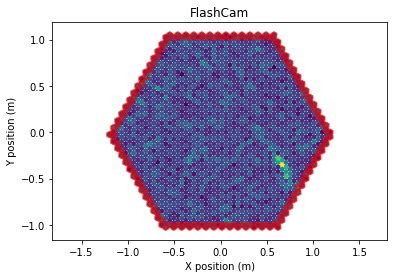

In [140]:
display = CameraDisplay(camera)
display.image = dl1.image[0]
display.highlight_pixels(camera.get_border_pixel_mask(1), linewidth=2, color='xkcd:red')

In [141]:
n_islands, island_id = number_of_islands(camera, clean)

print(n_islands)

1


In [142]:
conc = concentration(camera, dl1.image[0], hillas)
print(conc)

{'concentration_cog': 0.2867498655630528,
 'concentration_core': 0.30123570834050434,
 'concentration_pixel': 0.15565870887027622}


### Putting it all together / Stereo reconstruction

In [143]:
import astropy.units as u

from ctapipe.io import event_source
from ctapipe.utils.datasets import get_dataset_path

from ctapipe.calib import CameraCalibrator

from ctapipe.image.cleaning import tailcuts_clean, number_of_islands
from ctapipe.image import hillas_parameters, leakage, concentration
from ctapipe.image.timing_parameters import timing_parameters

from ctapipe.reco import HillasReconstructor

from ctapipe.io import HDF5TableWriter

from copy import deepcopy
import tempfile

# unoptimized cleaning levels, copied from 
# https://github.com/tudo-astroparticlephysics/cta_preprocessing
cleaning_level = {
    'ASTRICam': (5, 7, 2),  # (5, 10)?
    'LSTCam': (3.5, 7.5, 2),  # ?? (3, 6) for Abelardo...
    'FlashCam': (4, 8, 2),  # there is some scaling missing?
}


input_url = get_dataset_path('gamma_test_large.simtel.gz')
source = event_source(input_url)

calibrator = CameraCalibrator()

reco = HillasReconstructor()

f = tempfile.NamedTemporaryFile(suffix='.hdf5')

with HDF5TableWriter(f.name, mode='w', group_name='events') as writer:
    
    for event in source:
        print('Id: {}, E = {:1.3f}, Telescopes: {}'.format(event.count, event.mc.energy, len(event.r0.tel)))
        
        calibrator(event)

        # mapping of telescope_id to parameters for stereo reconstruction
        hillas_containers = {}
        pointing_azimuth = {}
        pointing_altitude = {}
        time_gradients = {}

        for telescope_id, dl1 in event.dl1.tel.items():
            camera = event.inst.subarray.tels[telescope_id].camera
            image = dl1.image[0]
            peakpos = dl1.pulse_time[0]

            boundary, picture, min_neighbors = cleaning_level[camera.cam_id]

            clean = tailcuts_clean(
                camera, 
                image,
                boundary_thresh=boundary,
                picture_thresh=picture,
                min_number_picture_neighbors=min_neighbors
            )

            # require more than five pixels after cleaning in each telescope
            if clean.sum() < 5:
                continue

            hillas_c = hillas_parameters(camera[clean], image[clean])
            leakage_c = leakage(camera, image, clean)
            n_islands, island_ids = number_of_islands(camera, clean)

            # remove events with high leakage
            if leakage_c.leakage2_intensity > 0.2:
                continue

            timing_c = timing_parameters(camera[clean], image[clean], peakpos[clean], hillas_c)

            hillas_containers[telescope_id] = hillas_c

            # ssts have no timing in prod3b, so we'll use the skewness
            time_gradients[telescope_id] = timing_c.slope.value if camera.cam_id != 'ASTRICam' else hillas_c.skewness

            # this makes sure, that we get an arrow in the array plow for each telescope
            # might have the wrong direction though
            if abs(time_gradients[telescope_id]) < 0.2:
                time_gradients[telescope_id] = 1.0

            pointing_azimuth[telescope_id] = event.mc.tel[telescope_id].azimuth_raw * u.rad
            pointing_altitude[telescope_id] = event.mc.tel[telescope_id].altitude_raw * u.rad

        if len(hillas_containers) > 1:
            stereo = reco.predict(
                hillas_containers, event.inst, pointing_altitude, pointing_azimuth
            )

            writer.write('reconstructed', stereo)
            writer.write('true', event.mc)
    
            print('  Alt: {:.2f}°'.format(stereo.alt.deg))
            print('  Az: {:.2f}°'.format(stereo.az.deg))
            print('  Hmax: {:.0f}'.format(stereo.h_max))
            print('  CoreX: {:.1f}'.format(stereo.core_x))
            print('  CoreY: {:.1f}'.format(stereo.core_y))
        
        # save a nice event for plotting later
        if event.count == 3:
            plotting_event = deepcopy(event)
            plotting_hillas = hillas_containers
            plotting_timing = time_gradients
            plotting_stereo = stereo
    

Id: 0, E = 0.571 TeV, Telescopes: 4
  Alt: 66.37°
  Az: -7.85°
  Hmax: 8963 m
  CoreX: 114.8 m
  CoreY: -414.8 m
Id: 1, E = 1.864 TeV, Telescopes: 9
  Alt: 68.25°
  Az: -353.42°
  Hmax: 6745 m
  CoreX: -48.6 m
  CoreY: -394.2 m
Id: 2, E = 1.864 TeV, Telescopes: 4
  Alt: 68.50°
  Az: -354.34°
  Hmax: 6988 m
  CoreX: -419.1 m
  CoreY: -574.4 m
Id: 3, E = 1.864 TeV, Telescopes: 17
  Alt: 68.48°
  Az: -353.40°
  Hmax: 6730 m
  CoreX: 44.5 m
  CoreY: 68.0 m
Id: 4, E = 1.864 TeV, Telescopes: 2
  Alt: 68.66°
  Az: -353.31°
  Hmax: 6305 m
  CoreX: -1095.7 m
  CoreY: 474.8 m
Id: 5, E = 0.464 TeV, Telescopes: 7
  Alt: 71.92°
  Az: -1.07°
  Hmax: 8684 m
  CoreX: -66.1 m
  CoreY: 289.6 m
Id: 6, E = 0.017 TeV, Telescopes: 2
  Alt: 70.53°
  Az: -358.01°
  Hmax: 10685 m
  CoreX: -157.5 m
  CoreY: -221.7 m
Id: 7, E = 76.426 TeV, Telescopes: 4
  Alt: 73.99°
  Az: -354.24°
  Hmax: 9952 m
  CoreX: 11.4 m
  CoreY: -1121.3 m
Id: 8, E = 76.426 TeV, Telescopes: 16
  Alt: 75.26°
  Az: -353.93°
  Hmax: 5818 m


  Alt: 69.26°
  Az: -7.30°
  Hmax: 8030 m
  CoreX: 93.0 m
  CoreY: 864.4 m
Id: 97, E = 1.620 TeV, Telescopes: 7
  Alt: 69.19°
  Az: -6.59°
  Hmax: 7696 m
  CoreX: 316.7 m
  CoreY: -594.1 m
Id: 98, E = 0.112 TeV, Telescopes: 3
  Alt: 70.67°
  Az: -358.12°
  Hmax: 9389 m
  CoreX: -22.3 m
  CoreY: -344.7 m
Id: 99, E = 0.322 TeV, Telescopes: 2
  Alt: 69.40°
  Az: -359.91°
  Hmax: 6798 m
  CoreX: -538.2 m
  CoreY: 62.1 m
Id: 100, E = 0.322 TeV, Telescopes: 10
  Alt: 69.43°
  Az: -0.75°
  Hmax: 7702 m
  CoreX: -178.2 m
  CoreY: -223.8 m
Id: 101, E = 6.104 TeV, Telescopes: 4
Id: 102, E = 0.245 TeV, Telescopes: 3
Id: 103, E = 0.636 TeV, Telescopes: 2
Id: 104, E = 0.636 TeV, Telescopes: 4
Id: 105, E = 1.824 TeV, Telescopes: 6
  Alt: 70.24°
  Az: -0.74°
  Hmax: 7229 m
  CoreX: -613.1 m
  CoreY: -411.6 m
Id: 106, E = 1.824 TeV, Telescopes: 2
Id: 107, E = 1.824 TeV, Telescopes: 3
  Alt: 70.19°
  Az: -0.60°
  Hmax: 6812 m
  CoreX: 822.3 m
  CoreY: -124.5 m
Id: 108, E = 0.538 TeV, Telescopes: 5
  Al

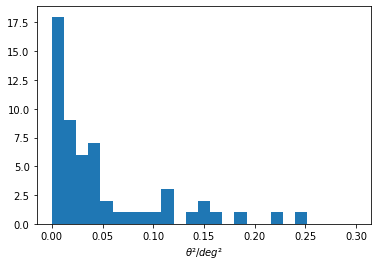

In [144]:
from astropy.coordinates.angle_utilities import angular_separation
import pandas as pd


df_rec = pd.read_hdf(f.name, key='events/reconstructed')
df_true = pd.read_hdf(f.name, key='events/true')


theta = angular_separation(
    df_rec.az.values * u.deg, df_rec.alt.values * u.deg,
    df_true.az.values * u.deg, df_true.alt.values * u.deg,
)

plt.hist(theta.to(u.deg).value**2, bins=25, range=[0, 0.3])
plt.xlabel(r'$\theta² / deg²$')
None

## ArrayDisplay


(-400, 400)

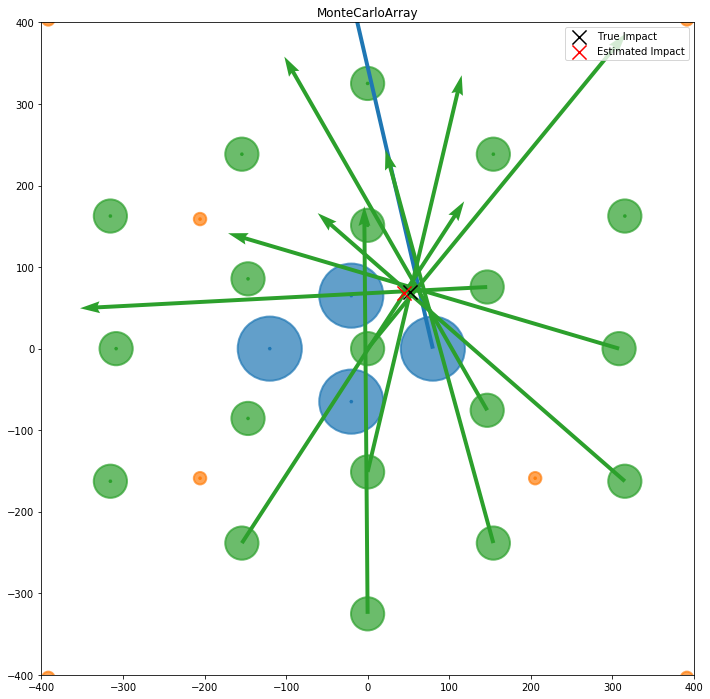

In [146]:
from ctapipe.visualization import ArrayDisplay

plt.figure(figsize=(12,12))

angle_offset = plotting_event.mcheader.run_array_direction[0]


disp = ArrayDisplay(plotting_event.inst.subarray)

disp.set_vector_hillas(
    plotting_hillas,
    time_gradient=plotting_timing,
    angle_offset=angle_offset,
    length=500
)

plt.scatter(
    plotting_event.mc.core_x, plotting_event.mc.core_y,
    s=200, c='k', marker='x', label='True Impact',
)
plt.scatter(
    plotting_stereo.core_x, plotting_stereo.core_y,
    s=200, c='r', marker='x', label='Estimated Impact',
)

plt.legend()
plt.xlim(-400, 400)
plt.ylim(-400, 400)

## LST Mono with output


* Let's use the `HDF5TableWriter` to save the dl1 Hillas parameter data to an hdf5 file
* This is not ideal yet and one of the major points to be discussed in two weeks

In [147]:
from ctapipe.io import HDF5TableWriter
from ctapipe.core.container import Container, Field

input_url = get_dataset_path('gamma_test_large.simtel.gz')

source = event_source(
    input_url=input_url,
    allowed_tels=[1, 2, 3, 4], # only use the first LST
)


calibrator = CameraCalibrator()


class EventInfo(Container):
    event_id = Field('event_id')
    obs_id =  Field('obs_id')
    telescope_id = Field('telescope_id')
    


with HDF5TableWriter(filename='hillas.h5', group_name='dl1', mode='w') as writer:

    for event in source:
        print('Id: {}, E = {:1.3f}, Telescopes: {}'.format(event.count, event.mc.energy, len(event.r0.tel)))
    
        calibrator(event)
    
        for telescope_id, dl1 in event.dl1.tel.items():      

            camera = event.inst.subarray.tels[telescope_id].camera
            image = dl1.image[0]
            peakpos = dl1.pulse_time[0]

            boundary, picture, min_neighbors = cleaning_level[camera.cam_id]

            clean = tailcuts_clean(
                camera, 
                image,
                boundary_thresh=boundary,
                picture_thresh=picture,
                min_number_picture_neighbors=min_neighbors
            )
            
            if clean.sum() < 5:
                continue
            
            event_info = EventInfo(event_id=event.r0.event_id, obs_id=event.r0.obs_id, telescope_id=telescope_id)
            hillas_c = hillas_parameters(camera[clean], image[clean])
            leakage_c = leakage(camera, image, clean)
            timing_c = timing_parameters(camera[clean], image[clean], peakpos[clean], hillas_c)

            writer.write('events', [event_info, event.mc, hillas_c, leakage_c, timing_c])
    


Id: 0, E = 1.864 TeV, Telescopes: 2
Id: 1, E = 0.017 TeV, Telescopes: 2
Id: 2, E = 0.010 TeV, Telescopes: 2
Id: 3, E = 0.121 TeV, Telescopes: 4
Id: 4, E = 0.032 TeV, Telescopes: 3
Id: 5, E = 0.073 TeV, Telescopes: 1
Id: 6, E = 0.129 TeV, Telescopes: 1
Id: 7, E = 0.079 TeV, Telescopes: 2
Id: 8, E = 0.127 TeV, Telescopes: 3
Id: 9, E = 0.147 TeV, Telescopes: 1
Id: 10, E = 0.103 TeV, Telescopes: 1
Id: 11, E = 0.078 TeV, Telescopes: 1
Id: 12, E = 0.592 TeV, Telescopes: 1
Id: 13, E = 0.066 TeV, Telescopes: 2
Id: 14, E = 0.017 TeV, Telescopes: 3
Id: 15, E = 0.009 TeV, Telescopes: 2
Id: 16, E = 0.248 TeV, Telescopes: 4
Id: 17, E = 5.327 TeV, Telescopes: 3
Id: 18, E = 0.407 TeV, Telescopes: 4
Id: 19, E = 0.037 TeV, Telescopes: 3
Id: 20, E = 0.020 TeV, Telescopes: 4
Id: 21, E = 0.710 TeV, Telescopes: 3
Id: 22, E = 0.055 TeV, Telescopes: 2
Id: 23, E = 0.032 TeV, Telescopes: 2
Id: 24, E = 0.118 TeV, Telescopes: 1
Id: 25, E = 0.142 TeV, Telescopes: 1
Id: 26, E = 0.189 TeV, Telescopes: 4
Id: 27, E =

In [148]:
import pandas as pd

df = pd.read_hdf('hillas.h5', key='dl1/events')
df.set_index(['obs_id', 'event_id', 'telescope_id'], inplace=True)
df.head()

alt        az      core_x      core_y  \
obs_id event_id telescope_id                                                
7514   31012    2             68.478978  6.384091   51.675117   69.654037   
                3             68.478978  6.384091   51.675117   69.654037   
       90914    2             70.676229  3.107417 -113.833435 -142.343872   
                4             70.676229  3.107417 -113.833435 -142.343872   
       153614   1             68.949967  2.666187  -51.531204 -106.752579   

                              deviation    energy   h_first_int     intensity  \
obs_id event_id telescope_id                                                    
7514   31012    2              0.735802  1.863750  18171.726562    475.328941   
                3              0.726013  1.863750  18171.726562  11588.493000   
       90914    2              0.237200  0.016544  15776.052734     78.789463   
                4              0.478937  0.016544  15776.052734    110.688692   
       153614   1              0.113214  0.010250  19824.572266     76.273207   

                              intercept  kurtosis  ...         phi        psi  \
obs_id event_id telescope_id                       ...                          
7514   31012    2             10.764946  2.039225  ...  156.993637  61.214904   
                3             12.362944  3.557758  ...  130.640290 -76.968753   
       90914    2              9.338677  2.445689  ...   51.256988  51.701245   
                4              8.797758  2.086657  ...   69.194528  82.347736   
       153614   1              8.748282  2.766870  ...  118.223829  73.286384   

                                     r  shower_primary_id  skewness     slope  \
obs_id event_id telescope_id                                                    
7514   31012    2             1.046389                  0  0.229954 -4.649106   
                3             0.841146                  0  0.954208  1.905143   
       90914    2             0.901478                  0 -0.056639  6.467751   
                4             0.961931                  0  0.050001 -0.163486   
       153614   1             0.966727                  0 -0.310947 -4.865826   

                                 width         x       x_max         y  
obs_id event_id telescope_id                                            
7514   31012    2             0.044190 -0.963161  379.538452  0.408964  
                3             0.109389 -0.547845  379.538452  0.638273  
       90914    2             0.017989  0.564170  184.545456  0.703117  
                4             0.024432  0.341674  184.545456  0.899205  
       153614   1             0.020285 -0.457182  241.111115  0.851789  

[5 rows x 25 columns]